In [1]:
import os # provides methods for interacting with the operating system.

import numpy as np # Numerical Python, universal standard for working with numerical data.

import cv2 as cv # OpenCv.

import matplotlib.pyplot as plt # Most of Matplotlib utilities under the plt alias.
import matplotlib.image as mpimg # Basic image loading, rescaling and display.
%matplotlib inline

from PIL import Image # Image module of Python Imaging Library.

from IPython.display import display # Public API for display tools in IPython.

import torch # PyTorch: Tensor computation with strong GPU acceleration.
import torch.nn as nn # Pytorch module for neural network creation and training.
import torch.nn.functional as F # Convolution, pooling, activation and attention functions.
from torch.utils.data import DataLoader #  Python iterable over a dataset.
from torchvision import datasets, transforms, models # popular datasets, model architectures, and common image transformations for computer vision.
from torch.optim.lr_scheduler import StepLR # Decays the learning rate of each parameter group by gamma every step_size epochs.
#from torchsummary import summary #: apparently torchsummary is dead. Use torchinfo.
from torchinfo import summary 
from tqdm import tqdm # Show a smart progress meter.

### Data:

• *Steps*

-  Create an image classifier over a dataset of x-ray images of lungs with pneumonia and normal lungs.
-  Download dataset and place in local directory, accessible by the Python compiler. We will use open source data, found at: *https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images*
-  The dataset is divided into test and train folders, each further divided into NORMAL and PNEUMONIA categories.

   - *The number of train samples in the NORMAL category is 1349.*
   - *The number of train samples in the PNEUMONIA category is 3883*
   - *The number of test samples in the NORMAL category is 234*
   - *The number of test samples in the PNEUMONIA category is 390*

*( cv.imread() from OpenCv and plt.show() from matplotlib )*

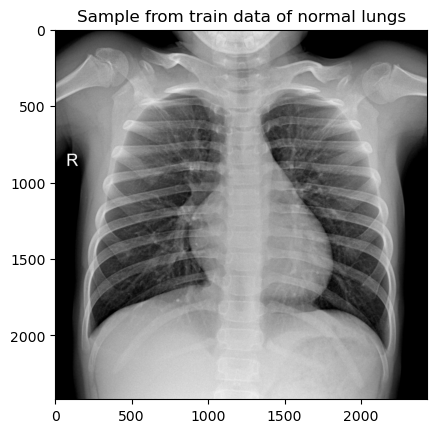

In [2]:
img_1 = cv.imread(r'img/chest_xray/train/NORMAL/NORMAL-28501-0001.jpeg')
plt.imshow(img_1)
plt.title('Sample from train data of normal lungs')
plt.show()

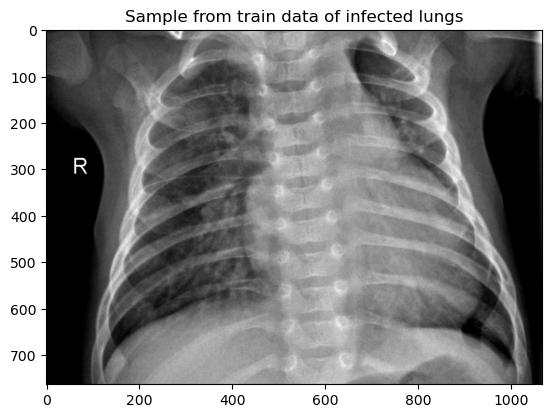

In [3]:
img_2 = cv.imread(r'img/chest_xray/train/PNEUMONIA/BACTERIA-7422-0001.jpeg')
plt.imshow(img_2)
plt.title('Sample from train data of infected lungs')
plt.show()

#### Imports:

 GPU is better for a faster process but CPU should also work. We need to install PyTorch, with CUDA support, in case we are using local CUDA cores. We need to be carefull about all the objects placed in CUDA for processing and all the objects placed in the CPU for processing.

 *The intermingling of data across different processor types is not supported unless they are specifically cast*. 

 *The custom libraries required for these classification problems have been listed in the beginning of this notebook*


Finally we set a data path for the data directory:


In [4]:
data_path = 'img\chest_xray'

### Data Exploration:

 We will now explore and check the sanity of the data. We have to assign *train* and *test* folders that can be used in the model. We can use the folder name as the class name if the images are segregated by folders. (*There can be another variation where we can see all images in one folder and then specify which image path belongs to which class.*)

In [5]:
class_name = ['NORMAL', 'PNEUMONIA'] # Define a list.
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

- Define the function with `dirName` argument.Takes a directory path `(dirName)` as input and returns a list of files present in that directory using `os.listdir.`  
- `os.listdir(dirName)` Returns the list of all files and directories in the specified directory.

>*Here we define a Python function `get_list_files` and use it to obtain lists of filenames in different directories:*

##### *Call the `get_list_files()` function to see the number of test samples*:
- `data_path` variable is defined above
- `class_name[0]` is the 0 index item in the class_name list i.e 'NORMAL'

In [6]:
files_list_normal_train = get_list_files(data_path + '/train/' + class_name[0])
print(f'Train samples in Normal category: {len(files_list_normal_train)}')

files_list_pneumonia_train = get_list_files(data_path + '/train/' + class_name[1])
print(f'Train samples in Pneumonia category: {len(files_list_pneumonia_train)}')

files_list_normal_test = get_list_files(data_path + '/test/' + class_name[0])
print(f'Test samples in Normal category: {len(files_list_normal_test)}')

files_list_pneumonia_test = get_list_files(data_path + '/test/' + class_name[1])
print(f'Test samples in Pneumonia category: {len(files_list_pneumonia_test)}')


Train samples in Normal category: 1349
Train samples in Pneumonia category: 3883
Test samples in Normal category: 234
Test samples in Pneumonia category: 390


##### *View samples*

*Now that we have counted the images and located their path, let's see how to view the sample images from NORMAL and PNEUMONIA folders:*

- define `rand_img_no` variable with `np.random.randint` that returns random integers. `np.random.randint(0,len(files_list_normal_train))` generates a random integer using Numpy's randint function. The first argument (0) is the inclusive lower bound, and the second argument `(len(files_list_normal_train))` is the exclusive upper bound. It means the random integer can be any value from 0 to the length of `files_list_normal_train` minus 1. $[x,y)$
- `img` variable, contains the full file path to a randomly selected image from the 'NORMAL' class in the training set.

Image dimensions: (1480, 1724)


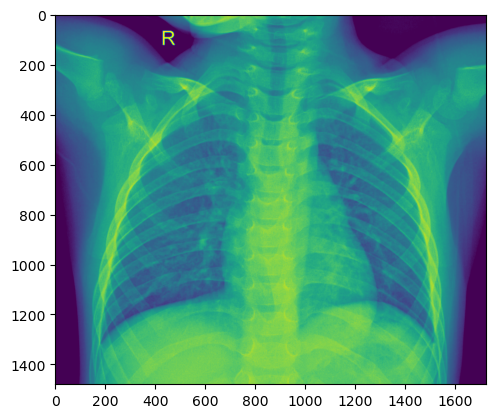

In [7]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(f'Image dimensions: {plt.imread(img).shape}')
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

- `imread().shape` retrieves the dimensions (shape) of the image.
- `mpimg.imread(img)`  reads the image with Matplotlib.
- `plt.imshow(img)`  Displays the image with imshow.
- `plt.show()` shows the image; without this, the image would be created but not displayed.

### Data Loader
 
Now that we have explored the data, let's setup the data loaders for training purposes. We will crop and resize the images to a uniform size of $224x224$. This is not set in stone, a different size can be used.  
 We will also convert the images to tensors for the PyTorch framework. We will try to normalize the images with mean and standard deviation values. *Subtracting the mean centers the input to 0, and dividing by the standard deviation makes any scaled feature value the number of standard deviations away from the mean.* $z\equiv\frac{ x - μ}{σ}$
 If we are considering three channels per image, then we need to provide three values for one channel. We need one combination of mean and standard deviation.

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

- `transforms.Resize(224)`: Resizes the image to have a minimum size of 224. If the image is smaller than this size, it will be scaled up. If it's larger, it will be scaled down.
- `transforms.CenterCrop(224)`: Performs a center crop on the image, extracting a square region of size 224x224 pixels. This is often used to create square input images.
- `transforms.ToTensor()`: Converts the image to a PyTorch tensor. PyTorch tensors are the primary data structure used in PyTorch for storing and manipulating multi-dimensional arrays.
- `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: Normalizes the tensor. This involves subtracting the mean and dividing by the standard deviation. The values `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` are the mean and standard deviation values for the three color channels (RGB). These *specific values* are often used for normalization when working with models pretrained on large datasets like ImageNet.*( see: https://stackoverflow.com/questions/65676151how-does-torchvision-transforms-normalize-operate)*.
- The `transforms.Compose` function is then used to combine these transformations into a single transform that can be applied to an image.

> *Normalizing data includes them in the same range as our activation functions, usually between 0 and 1. This allows for less frequent non-zero gradients during training, and therefore the neurons in our network will learn faster.By normalizing each channel so that they have the same distribution, we ensure that the channel information can be mixed and updated during the gradient descent (back propagation) using the same learning rate.*

In [9]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

- `train_data` and `test_data` are instances of the `Imagefolder` class representing the training and testing datasets, respectively. These will be used with PyTorch's `Dataloader` for iterating through batches during training or evaluation.
- `ImageFolder` class, automatically assigns labels to images based on the subdirectory they are in.
- The `os.path.join(data_path, 'train/test')` command is used to create a path by joining the data_path variable with the subdirectory `'train/test'`.
- The `transform` argument applies the specified transformations.

In [10]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)
class_names =  train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


- `DataLoader` is a PyTorch utility for loading and batching data.
- `train_loader` is the variable where `DataLoader` stores the training dataset(`train_data`), `test_loader` is the variable where `DataLoader` stores the testing dataset (`test_data`).
- `batch_size` specifies the number of samples (images) in each mini-batch.
- `shuffle` is set to *True* only in the `train_loader`. This means that the data will be shuffled at the beginning of each epoch. This is essential in order to avoid the model learning patterns based on the order of the data. In the case of the testing data, the shuffle needs to be turned off.
- `pin_memory=True` pins/pushes data initially loaded in the CPU, to the GPU. The process is faster when pin memory is enabled.
- `train_data.classes` contains the class labels (names) found in the dataset.With this we can see what classes the model is trained on.

> * **Epoch**: An epoch in machine learning is one complete pass through the entire training dataset. *One epoch* is complete when the model has processed **all the batches and
updated its parameters** based on calculated loss (cost function).
*(see: https://www.geeksforgeeks.org/epoch-in-machine-learning/)*

>To sum up: The DataLoader is configured to load the training data in mini-batches of size 16 and the testing data in mini-batches of size 1. This is common in machine learning, where training is often done in mini-batches for efficiency. The shuffle parameter is set to True for the training data loader, meaning that the data will be shuffled at the beginning of each epoch.

### Defining the Model:

The model architecture will be defined with convolution blocks and use ReLU as an activation layer. The baseline model will have 12 convolution blocks, including one convolution block to set up the input and one for the output. The first three have one max pooling function, to reduce dimentions by filtering information.

- **Convolution Blocks**:  A convolutional block is a general term used to describe a sequence of layers in a CNN that are often repeatedly used in the feature extractor.

<img src="img/VGG16.JPG" style="display:block; margin:auto">

*Convolutional blocks, in a well-known CNN called VGG-16. source: (https://learnopencv.com/understanding-convolutional-neural-networks-cnn/)*
- **Pooling Layer**: This layer is usually added after the convolutional layer. Pooling layer reduces the spatial size of the output from convolutional layer and extracts dominant features.
  - · Max Pooling returns the maximum value from the portion of the image covered by kernel.
  - · Average Pooling returns the average value from the portion of the image covered by kernel.

<img src="img/max_pooling.JPG" style="display:block; margin:auto">

*<p style="text-align: center;">Source: Researchgate</p>*

- ReLU (Rectified Linear Unit) function: 
  
  <img src="img/ReLU_form.JPG" style="display:block; margin:auto">

  *<p style="text-align: center;">Source: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)</p>*
  
  <img src="img/ReLU.JPG" style="display:block; margin:auto">
*<p style="text-align: center;">Outputs the input directly if it is positive, otherwise, it will output zero.</p>*
  

### *Model Definition*:

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        #INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        )
        self.pool11 = nn.MaxPool2d(2,2)

        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2,2)

        # TRANSITION BLOCK
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU()
            #nn.BatchNorm2d(10),
        )
        self.pool33 = nn.MaxPool2d(2,2)

        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4,4), padding=0, bias=False),
        )

    def forward(self,x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)

        x = x.view(-1,2)
        return F.log_softmax(x, dim=-1)

The code above is a convolutional neural network class definition (CNN).  

```python
class Net(nn.Module):  
    def __init__(self):  
        super(Net, self).__init__()
```
- `class Net(nn.Module):` Defines a class named `Net`, that is a subclass of `nn.Module`.  
`Net` inherits the properties and methods of `nn.Module`, which is a base class for all neural network modules in PyTorch.
- The `__init__ `function is called a constructor, or initializer, and is automatically called when you create a new instance of a class.
- `self`: Let's say you have a class `ClassA` which contains a method `methodA` defined as:
  ```python
    class ClassA:
      def methodA(self, arg1, arg2):
          ... # do something
  ```
  and `objectA` is an instance of this class.
  Now when `objectA.methodA(arg1, arg2)` is called, python internally converts it for you as: `ClassA.methodA(objectA, arg1, arg2)`.  
  **The `self` variable refers to the object itself.**

- In Python, the `super()` function is used to refer to the parent *class* or *superclass*. It allows you to call methods defined in the superclass from the subclass, enabling you to extend and customize the functionality inherited from the parent class. *See (https://www.geeksforgeeks.org/python-super/)*. `super(Net, self).__init__()` is calling the constructor of the parent class (nn.Module). This is necessary to properly initialize the Net object as a PyTorch module.

- `convblock` is a combination of a 2D convolutional layer, followed by a ReLU activation function. 
  - `nn.Conv2d`:  
    - `in_channels`: The number of input channels. 3 is typical for RGB.
    - `out_channels`: The number of output channels, or the number of filters/kernels used in the convolution. Each filter produces one channel in the output.
    - `kernel_size`: The size of the convolutional filter/kernel.
    - `padding`: The amount of pixels added to an image when it is being processed by the kernel of a CNN. During convolution, the size of the output feature map is determined by the size of the input feature map, the size of the kernel, and the stride. if we simply apply the kernel on the input feature map, then the output feature map will be smaller than the input. This can result in the loss of information at the borders of the input feature map. In Order to preserve the border information we use padding.Padding involves adding extra pixels around the border of the input feature map before convolution. 
    - >For a grayscale $(nxn)$ image and $(fxf)$ filter/kernel, the dimentions of the image resulting from a convolution is: $(n-f+1)x(n-f+1)$. Thus the image *shrinks every time a convolution operation is performed.*


      <img src="img/padding.gif" style="display:block; margin:auto"> \
      
    - `bias`: For a typical neuron,  with $x_i$ inputs and $w_i$ weights, the output is: $y = f(x) = \sum x_i w_i$. This is the *weighted sum*. In simple words, neural network bias can be defined as the constant which is added to the product of features and weights. It is used to *offset the result*. It helps the models to **shift the activation function towards the positive or negative side**. The processing done by a neuron is thus denoted as : $output = \sum x_i w_i + bias$. *see(https://www.turing.com/kb/necessity-of-bias-in-neural-networks)*
  - `ReLU`: This is the rectified linear unit activation function. It introduces non-linearity to the model by outputting the input directly if it is positive; otherwise, it outputs zero.
  - `nn.Sequential`: Is a container for a sequence of layers. It applies each layer to the input data, in sequence. In this case, it first applies the convolutional layer and then the ReLU activation function. *Containers are any object that holds an arbitrary number of other objects. Generally, containers provide a way to access the contained objects and to iterate over them.*
  - `self.gap`: This defines a Global Average Pooling (GAP) layer in the neural network.
    - `nn.AvgPool2d`:
      - `kernel_size`: This is the size of the window over which each pooling operation is performed. 
    - > Pooling essentially takes groups of pixels and performs an aggregation (συνάθροιση) over them. It can be ether **Max Pooling** *(grabs the maximum value pixel)* or **Average Pooling.** *(replaces the pixel area with an average)*
- `def forward()`: This method defines the *forward pass* of the neural network. It describes how the input data is proccessed trough the layers to produce the output.

### Model Explanation:
1. **The Input Block**: The model receives a three - channel $224x224$ input and uses a  convolution by $3x3$ to generate $222x222$ and eight channels. This is followed by the ReLU  ctivation layer. No padding.  
2. **Convolution Block**: After the input the max pooling function reduces the feature map size to $111x111$.
3. After the pooling function works on the feature maps, the feature maps are convolved by $3x3$  to generate $16$ channels from $8$ and reducing the feature map dimension to $109x109$.
4. After we get $16$ channels, we use the max pooling  function again to bring the feature map dimension to $54x54$.
5. **Transition Block**: Reduces the number of channels from $16$ to $10$, followed by another max pooling function.
6. **Convolution Block**: After max pooling, the feature map dimension is now $27x27$. A $3x3$ kernel is used to convolve and create an equal number of feature maps.
7. The fifth and sixth convolution blocks are transition layers, wherein we increase the  number of layers from $10$ to $32$ and back to $10$. There is no padding as usual for this.
8. The seventh convolution block is used for $3x3$ convolution operations, but the channel size remains the same again.
9. Similar operations in the eighth and ninth convolution blocks. Using the transition convolutional operations, the channels change from $10$ to $32$ and back to $10$ again.
10. A $3x3$ convolution block is added, which is tenth in line. The number of feature maps is increased from $10$ to $14$.
11. The penultimate building block of the architecture is using a $3x3$ kernel to move the  number of channels from $14$ to $16$.
12. **Output Block**: In the output block, we use average pooling to bring in two-four  units from $19x19$. That can be used for the binary classification.*(It reduces the spatial dimensions to $1x1$, taking the average value over each feature map.Global average pooling is often used as a replacement for fully connected layers in the final layers of  convolutional neural networks.)* Following our average pooling, we use a convolution block of the same kernel size as of the feature map dimension  to bring that into a single unit for the output. *The choice of 2 output channels suggests a binary classification scenario, as the final layer has 2 output units.*
13. Finally, we use the *logarithmic softmax* function to produce the output. It is a scaled  output and we use the argmax function to determine the class per batch element. The softmax function, *converts a vector of K real numbers into a probability distribution of K possible outcomes*.
<img src="img/softmax.JPG" style="display:block; margin:auto">  
*It applies the standard exponential function to each element $z_{i}$ of the input vector $z$ and normalizes these values by dividing by the sum of all these exponentials. The normalization ensures that the sum of the components of the output vector σ (z) is 1.*

We can output the model in a GPU and see its summary:

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(f'Avaliable processor: {device}')
model = Net().to(device)
summary(model, input_size=(3,224,224), col_names=('output_size', 'num_params','kernel_size'))


Avaliable processor: cuda


Layer (type:depth-idx)                   Output Shape              Param #                   Kernel Shape
Net                                      [1, 2]                    --                        --
├─Sequential: 1-1                        [8, 222, 222]             --                        --
│    └─Conv2d: 2-1                       [8, 222, 222]             216                       [3, 3]
│    └─ReLU: 2-2                         [8, 222, 222]             --                        --
├─MaxPool2d: 1-2                         [8, 111, 111]             --                        2
├─Sequential: 1-3                        [16, 109, 109]            --                        --
│    └─Conv2d: 2-3                       [16, 109, 109]            1,152                     [3, 3]
│    └─ReLU: 2-4                         [16, 109, 109]            --                        --
├─MaxPool2d: 1-4                         [16, 54, 54]              --                        2
├─Sequential: 1-5       

- `Layer (type:depth-idx):` Type and depth index of each layer.
- `Output Shape:` Shape of the output tensor after each layer. For example, [8, 222, 222] means a tensor of shape (8, 222, 222).
- `Param #:` The number of parameters (weights and biases) for each layer.

- `Total params`: Total number of parameters, both trainable and not trainable.
- `Trainable params`: These will be updated during training.
- `Non-trainable params`: Usually associated with operations like barch normalization, where the mean and variance are not updated during training.
- `Total mult-adds (M)`: Estimated total of multiply-add operations im millions in a forward pass of the network. It's a measure of computational complexity.
- `Input size (MB)`: Memory required for the input data.
- `Forward/backward pass size (MB)`: Memory required for storing intermediate values during forward/backward passes.
- `Params size (MB)`: Memory required to store the parameters.
- `Estimated Total Size (MB)`: Estimated total memory that the model requires. Includes the input size, forward/backward pass size, and parameter size.

Some interpretations:

Convolutional Block 1:

- Input: 3 channels (for RGB), Output: 8 channels, Kernel Size: (3,3), No Padding.
- After ReLU activation, the output shape is [8, 222, 222].
- The convolutional layer has 216 parameters.

MaxPool2d 1-2:

- Performs max pooling with a kernel size of (2,2), reducing the spatial dimensions by half.
- The output shape becomes [8, 111, 111].

### The training process:

1. Initialize the gradient.
2. Get a prediction from the current model given the current weights.*Initially, the weights are randomly assigned from a distribution, using the Xavier or He initialization. (For a  ReLU activation network, He is used, whereas for sigmoid, Xavier is used.)*
3. Once the forward pass is complete, a loss is calculated that measures how far off the predictions are from the actual values.
4. Then we calculate the backward propagation given the accumulated loss.
5. Once the backward propagation loss computations are done, we move toward the optimizer step, which will use the learning rate and other arguments to refresh and update the  weights of the model.

Here is the code to prepare the data for training and testing:
- Initialize lists to store training and testing losses, as well as training and testing accuracies.
- Call `train` function for each epoch
- Call `test` fucntion to evaluate the model after each epoch.

In [18]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train() # Set model to training mode
    pbar = tqdm(train_loader)

    correct = 0
    proccessed = 0

    for batch_idx, (data, target) in enumerate(pbar): # Iterate over batches in training data
        # Get data
        data, target = data.to(device), target.to(device)

        # Initialization of gradient
        optimizer.zero_grad() # Zeroes the gradient

        # Prediction on data
        y_pred = model(data)

        # Calculate the loss, given the prediction. (Cost function)
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss) # appends loss to train_losses list

        # Backpropagation
        loss.backward()
        optimizer.step() # Update model parameters using optimizer

        # Track the training loss and accuracy
        # Get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        proccessed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/proccessed:.2f}')
        train_acc.append(100*correct/proccessed) # Appends % to train_acc list

def test(model, device, test_loader):
    model.eval() # Sets the model to evaluation mode.
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Computation of test accuracies and losses.
        for data, target in test_loader: # Iterate over batches in test data
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # Computes predicted output
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss) # appends test_losses to list test_loss

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset)))
    
    test_acc.append(100.*correct/len(test_loader.dataset))


The steps:
1. The `train()` function sets up the model for training.
2. `data.to(device)` and `target.to(device)`place the data in the GPU if the model is in GPU, or CPU if the model is in CPU. Initializing the device ensures the data and the model are on the same device during training.
3. `optimizer.zero_grad()` is a method in PyTorch that resets to zero the gradients of all the parameters that the optimizer will update, since PyTorch by default tries to accumulate a gradient. It is typically called at the beginning of the training loop before the forward and backward passes for each mini-batch. It ensures that the gradients are fresh for the current set of inputs and labels.
4. We use the data loader to generate batches of images and pass them on to the model for training.  
`for batch_idx, (data, target) in enumerate(pbar)`: Here, `pbar` is an iterator over the `train_loader`, which is the `DataLoader` for the training dataset. In each iteration, it loads a batch of data `(data)` and corresponding labels `(target)`.
5. `y_pred = model(data)`  is responsible for obtaining the model's predictions (y_pred) for the input data (data)
6. `loss = F.nll_loss(y_pred, target)` : Uses the negative log likelihood loss `(F.nll_loss)` to compute the loss between the model's predictions `(y_pred)` and the actual target labels `(target)`.*see: (https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6)* *The computed loss helps in backpropagation and helps the optimizer take an update of the weights of the models according to the direction of the steepest ascent/descent.*
7. `pred = y_pred.argmax(dim=1, keepdim=True)`: Here, `y_pred` is the output of the model, and `argmax(dim=1)` is used to find the **index of the maximum value along dimension 1**, which represents the predicted class. The result is stored in the `pred` variable.
8. ```python
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    ````
`output = model(data)` : Generates predictions using the model for the test data.  
`test_loss += F.nll_loss(output, target, reduction='sum').item():` This line calculates the test loss using negative log likelihood loss. The losses are accumulated.
`pred = output.argmax(dim=1, keepdim=True):` This line calculates the predicted class for each input in the test set.  
`correct += pred.eq(target.view_as(pred)).sum().item():` This line calculates the number of correctly predicted instances.

Now that we have computed the functions for our loss computation, back propagation, and weights, we can initiate the optimizers and schedulers to begin training. Here’s the code for the training process:

In [19]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()['param_groups'][0]['lr'])
    test(model, device, test_loader)


EPOCH: 0


Loss=0.693148136138916 Batch_id=326 Accuracy=29.15: 100%|██████████| 327/327 [03:48<00:00,  1.43it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 253/624(40.54%)

Values:  0.6931476474572451 253 624

Test set: Average loss: 0.6931, Accuracy: 253/624 (40.54%)

EPOCH: 1


Loss=0.6931470036506653 Batch_id=326 Accuracy=32.13: 100%|██████████| 327/327 [02:25<00:00,  2.24it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 269/624(43.11%)

Values:  0.6931474461960487 269 624

Test set: Average loss: 0.6931, Accuracy: 269/624 (43.11%)

EPOCH: 2


Loss=0.6931471824645996 Batch_id=326 Accuracy=35.59: 100%|██████████| 327/327 [02:25<00:00,  2.25it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 279/624(44.71%)

Values:  0.6931472455079739 279 624

Test set: Average loss: 0.6931, Accuracy: 279/624 (44.71%)

EPOCH: 3


Loss=0.6931466460227966 Batch_id=326 Accuracy=48.30: 100%|██████████| 327/327 [02:25<00:00,  2.25it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 339/624(54.33%)

Values:  0.6931470471123854 339 624

Test set: Average loss: 0.6931, Accuracy: 339/624 (54.33%)

EPOCH: 4


Loss=0.6931460499763489 Batch_id=326 Accuracy=68.62: 100%|██████████| 327/327 [02:25<00:00,  2.24it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931468452780675 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 5


Loss=0.693146824836731 Batch_id=326 Accuracy=73.93: 100%|██████████| 327/327 [02:25<00:00,  2.24it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931466256769804 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 6


Loss=0.6931450366973877 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:27<00:00,  2.22it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.693146501118556 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 7


Loss=0.6931463479995728 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:26<00:00,  2.23it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931463656708216 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 8


Loss=0.6931472420692444 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:27<00:00,  2.22it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.693146210641433 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 9


Loss=0.6931483745574951 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:27<00:00,  2.22it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931460335468634 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 10


Loss=0.693141758441925 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:26<00:00,  2.23it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931458309483833 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 11


Loss=0.693143367767334 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:26<00:00,  2.23it/s] 


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931456016042293 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 12


Loss=0.6931412816047668 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:26<00:00,  2.24it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931454740846769 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 13


Loss=0.6931432485580444 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:26<00:00,  2.23it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931453411204692 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH: 14


Loss=0.693139374256134 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:25<00:00,  2.24it/s] 


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

Values:  0.6931451973624718 390 624

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)



After 43 minutes, 15 epochs passed and we can see the results of the test phase:
- `current Learning Rate:  0.0025`: *Learning Rate*: This is a hyperparameter that determines the step size at each iteration while moving toward a minimum of a loss function(*gradient descent*). Too large a learning rate might cause the model to overshoot the minimum, and too small might cause the model to converge very slowly. Note the *Learning Rate* is being adjusted after every epoch.
- ` Average loss: 0.6931`: A measure of how well the model's prodictions match the actual target values.
- `Accuracy: 390/624 (62.50%)`: $390$ is the number of correctly classified samples.These are instances where the models predictions match the actual labels in the test set. $62.50%$ is calculated as the ratio of correctly classified samples to the total number of samples, expressed as a precentage.

Now we can analyze the loss pattern for the testing and training data:

Text(0.5, 1.0, 'Test Accuracy')

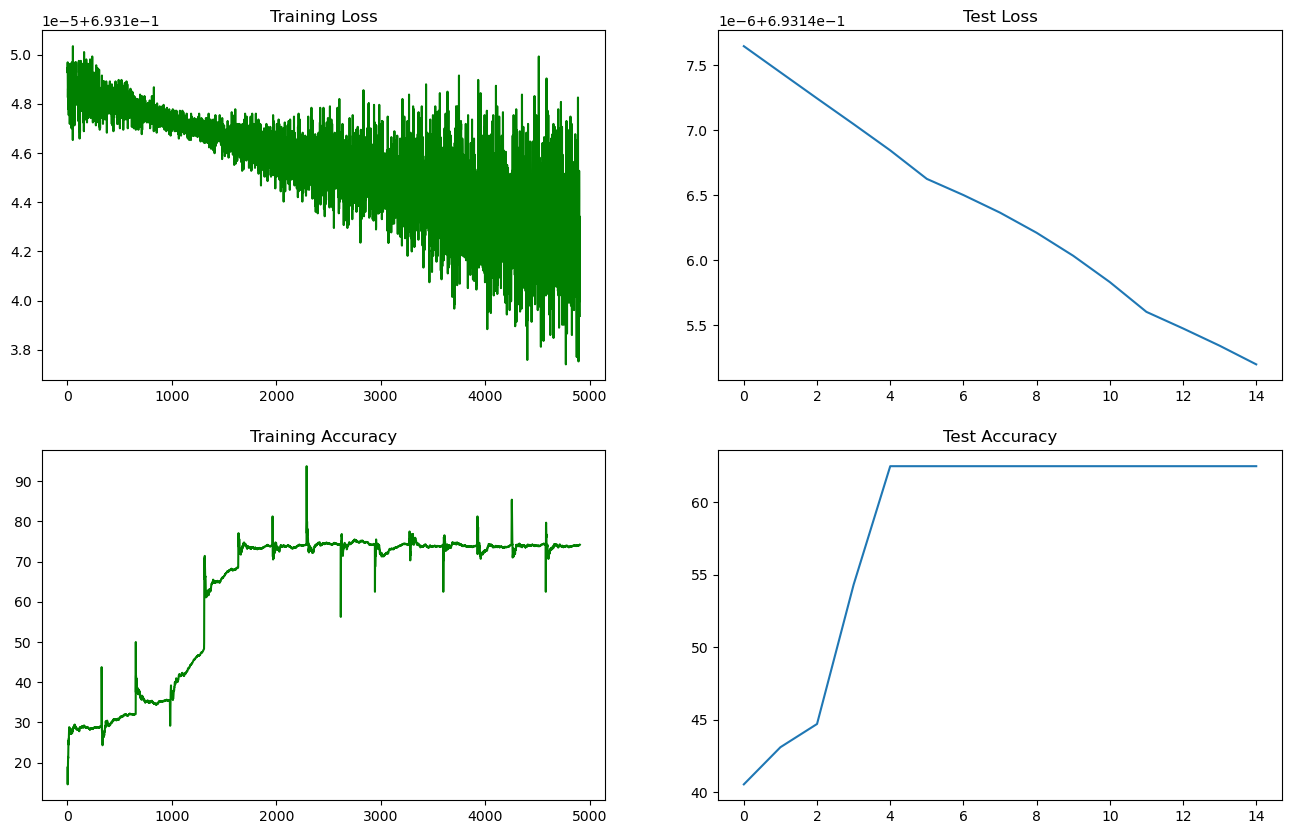

In [20]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2, 2, figsize = (16,10))

axs[0,0].plot(train_losses1, color='green')
axs[0,0].set_title('Training Loss')

axs[1,0].plot(train_acc1, color='green')
axs[1,0].set_title('Training Accuracy')

axs[0,1].plot(test_losses1)
axs[0,1].set_title('Test Loss')

axs[1,1].plot(test_acc1)
axs[1,1].set_title('Test Accuracy')


- **Training Loss** `(Loss={loss.item()})`: This is the value of the loss function on the training dataset. The loss function measures how well the model is performing. During training, the goal is to minimize this value. *How well the model is performing on the training data.* (x axis : mins)

- **Training Accuracy** `(Accuracy={float(100*correct/proccessed):.2f})`: This is the accuracy of your model on the training dataset. It's the percentage of correctly predicted samples out of the total number of training samples. *Percentage of correct predictions on the training data.* (x axis : mins)

- **Test Loss** `(Average loss: {:.4f})`: This is the value of the loss function on the test dataset. It indicates how well your model generalizes to unseen data. During training, you don't want just the training loss to decrease; you also want the test loss to be low, showing that the model is not overfitting. *How well the model generalizes to new, unseen data.* (x axis : epochs)

- **Test Accuracy** `(Accuracy: {}/{} ({:.2f}%))`: This is the accuracy of your model on the test dataset. It's the percentage of correctly predicted samples out of the total number of test samples. *Percentage of correct predictions on the test data.* (x axis : epochs)

Here, we notice that `Test Accuracy` reaches a maximum of $62.50\%$ after the $4$ th epoch.
Also we can see `Test Loss` decreasing steadily over the epochs.